In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

print(f'TensorFlow Version: {tf.__version__}')

TensorFlow Version: 2.3.1


# Data preprocessing

## Data download

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
print(f'Path of the ZIP: {path_to_zip}')

68608000/68606236 [==============================] - 7s 0us/step
Path of the ZIP: /home/jovyan/.keras/datasets/cats_and_dogs.zip


In [3]:
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
print(f'Path of the images: {PATH}')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
print(f'Path of train data: {train_dir}')
print(f'Path of validation data: {validation_dir}')

Path of the images: /home/jovyan/.keras/datasets/cats_and_dogs_filtered
Path of train data: /home/jovyan/.keras/datasets/cats_and_dogs_filtered/train
Path of validation data: /home/jovyan/.keras/datasets/cats_and_dogs_filtered/validation


In [4]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)
print(type(train_dataset))

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


In [5]:
for images, labels in train_dataset.take(1):
    print(images.shape)
    print(labels.shape)

(32, 160, 160, 3)
(32,)


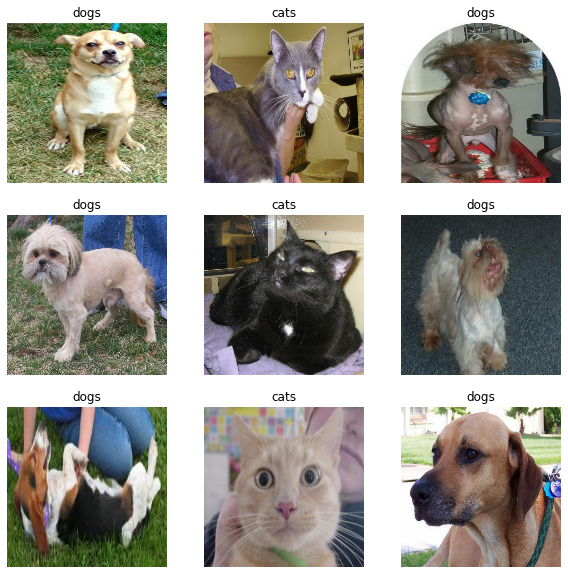

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [7]:
# 从valida_dataset中拆分出测试集
val_batches = tf.data.experimental.cardinality(validation_dataset) # 确定验证集中有多少个batch
test_dataset = validation_dataset.take(val_batches // 5) # 20%用作测试集
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


## Config the dataset for performance
- Use buffered prefetching to load images from disk without having I/O become blocking

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Use data augmentation

In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])  # 这些层在训练的时候才会被激活，推断的时候不会被激活

(160, 160, 3)


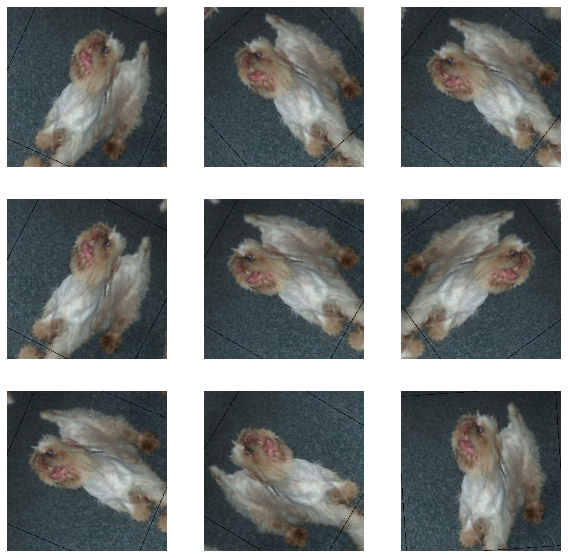

In [10]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    print(first_image.shape)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

## Rescale pixel values

In [12]:
# 归一化到[－１，　１]，　
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# Ｏｒ using Rescaling layer
# rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1. / 127.5, offset=-1)

# Create the base model from the pretrained convnets

In [13]:
IMG_SHAPE = IMG_SIZE + (3,)
print(IMG_SHAPE)

(160, 160, 3)


In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 379s 40us/step


In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [16]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

# Feature Extraction

## Freeze the convolutional base

In [17]:
base_model.trainable = False

## Important note about Batchnormlization layers
- 设置layer.trainable = False时，Batchnormalization会以推断模式运行，不会更改相应的均值方差
- 当你为了微调没有freeze带有batchnormalization层的模型时，调用该模型时应传入training=False使BN层以推断模式运行

## Add a classfication head

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [19]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch)

tf.Tensor(
[[ 0.40867168]
 [-0.8903561 ]
 [-0.33003756]
 [ 0.99931675]
 [ 0.23887604]
 [-0.8224796 ]
 [-2.3086631 ]
 [-0.8736494 ]
 [ 0.35208023]
 [-0.5283758 ]
 [-0.35713485]
 [-0.08342177]
 [-0.767031  ]
 [-1.2056639 ]
 [-1.5768546 ]
 [-1.2039135 ]
 [ 0.6055337 ]
 [-0.48620263]
 [-0.48163983]
 [-0.5000906 ]
 [-0.54297674]
 [-1.0946716 ]
 [-0.16170353]
 [-0.09567454]
 [-1.1765258 ]
 [-0.15054391]
 [-0.993067  ]
 [-0.95413625]
 [-0.76040083]
 [ 0.1793094 ]
 [-0.32018727]
 [-0.63386106]], shape=(32, 1), dtype=float32)


## Build Model by keras function API

In [20]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [21]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

## Compile the model
- 标签有两个类别，损失函数使用二分交叉熵损失函数，model最后是线性输出，设置from_logit=True

In [22]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
len(model.trainable_variables)

2

In [23]:
len(model.trainable_weights)

2

## Train the model 

In [24]:
# 查看模型初始精度
loss0, acc0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(acc0))

26/26 [==============================] - 3s 129ms/step - loss: 0.6358 - accuracy: 0.5978
initial loss: 0.64
initial accuracy: 0.60


In [25]:
initial_epochs = 10 
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 13s 214ms/step - loss: 0.6548 - accuracy: 0.5935 - val_loss: 0.4357 - val_accuracy: 0.7624
Epoch 2/10
63/63 [==============================] - 14s 218ms/step - loss: 0.4913 - accuracy: 0.7170 - val_loss: 0.3204 - val_accuracy: 0.8725
Epoch 3/10
63/63 [==============================] - 14s 215ms/step - loss: 0.3906 - accuracy: 0.8070 - val_loss: 0.2586 - val_accuracy: 0.9059
Epoch 4/10
63/63 [==============================] - 13s 213ms/step - loss: 0.3575 - accuracy: 0.8290 - val_loss: 0.2216 - val_accuracy: 0.9208
Epoch 5/10
63/63 [==============================] - 13s 209ms/step - loss: 0.2978 - accuracy: 0.8670 - val_loss: 0.1946 - val_accuracy: 0.9394
Epoch 6/10
63/63 [==============================] - 13s 209ms/step - loss: 0.2683 - accuracy: 0.8815 - val_loss: 0.1702 - val_accuracy: 0.9443
Epoch 7/10
63/63 [==============================] - 13s 210ms/step - loss: 0.2619 - accuracy: 0.8835 - val_loss: 0.1518 - val_accuracy: 0.9604

## Learn crves
- Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like tf.keras.layers.BatchNormalization and tf.keras.layers.Dropout affect accuracy during training. They are turned off when calculating validation loss.

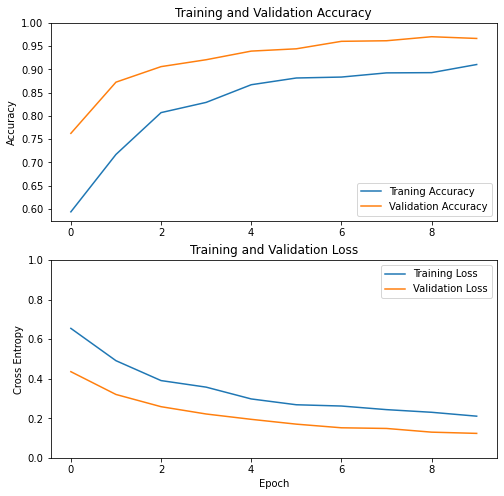

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Traning Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

# Fine Tune

## Un-freeze the top layers of the model

In [27]:
base_model.trainable = True
print(f'Number of layers in the base model: {len(base_model.layers)}')

Number of layers in the base model: 155


In [28]:
# fine-tune from this layer onwards
fine_tune_at = 100
# Freeze all the layers before the fine_tune_at layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [29]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

In [30]:
len(model.trainable_variables)

58

## Complie the model

In [31]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate / 10),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Continue training the model

In [32]:
fine_tune_epochs = 10 
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 19s 303ms/step - loss: 0.1566 - accuracy: 0.9405 - val_loss: 0.0609 - val_accuracy: 0.9790
Epoch 11/20
63/63 [==============================] - 19s 298ms/step - loss: 0.1225 - accuracy: 0.9560 - val_loss: 0.0542 - val_accuracy: 0.9777
Epoch 12/20
63/63 [==============================] - 18s 293ms/step - loss: 0.1218 - accuracy: 0.9510 - val_loss: 0.1088 - val_accuracy: 0.9616
Epoch 13/20
63/63 [==============================] - 19s 298ms/step - loss: 0.1105 - accuracy: 0.9570 - val_loss: 0.0517 - val_accuracy: 0.9876
Epoch 14/20
63/63 [==============================] - 19s 297ms/step - loss: 0.0968 - accuracy: 0.9590 - val_loss: 0.0519 - val_accuracy: 0.9765
Epoch 15/20
63/63 [==============================] - 19s 300ms/step - loss: 0.0891 - accuracy: 0.9680 - val_loss: 0.0482 - val_accuracy: 0.9814
Epoch 16/20
63/63 [==============================] - 19s 294ms/step - loss: 0.0870 - accuracy: 0.9640 - val_loss: 0.0415 - val_accuracy:

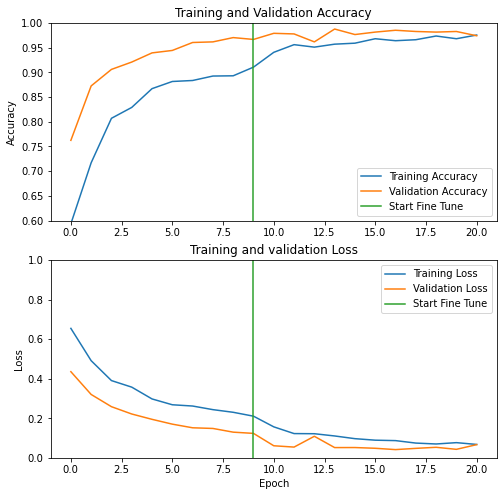

In [34]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.ylim([0.6, 1])
plt.plot([initial_epochs-1, initial_epochs-1], 
         plt.ylim(),
         label='Start Fine Tune')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylabel('Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1, initial_epochs-1,], 
         plt.ylim(),
         label='Start Fine Tune')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.title('Training and validation Loss')
plt.show()

## Evaluation and Prediction

In [35]:
loss, acc = model.evaluate(test_dataset)
print(f'Test Accuracy: {acc}')

6/6 [==============================] - 1s 114ms/step - loss: 0.0698 - accuracy: 0.9792
Test Accuracy: 0.9791666865348816


In [36]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print(f'Predictions: \n {predictions.numpy()}')
print(f'Labels: \n {label_batch}')

Predictions: 
 [0 0 1 1 0 1 0 1 1 1 0 1 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 1 0 1 0]
Labels: 
 [0 0 1 1 0 1 0 1 1 1 1 1 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 1 0 1 0]


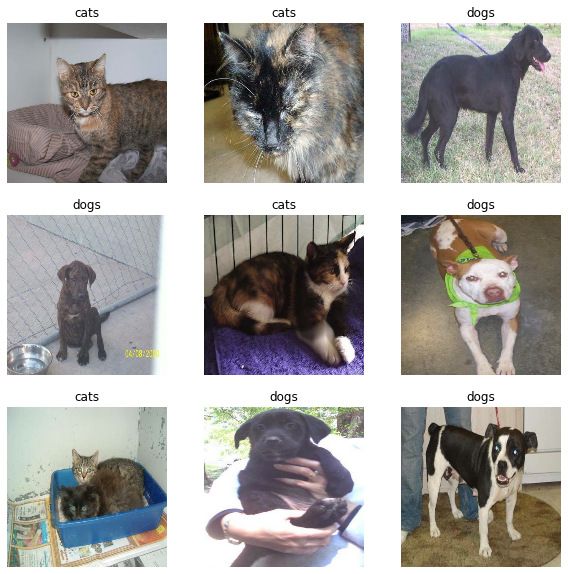

In [37]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(image_batch[i].astype('uint8'))
    plt.title(class_names[predictions[i]])
    plt.axis('off')